In [492]:
import yfinance as yf
import pandas as pd

# OBX = the 25 most liquid stocks 

start_date = pd.Timestamp('2006-01-01')
end_date = pd.Timestamp('2010-01-01')

obx = yf.Ticker("OBX.OL")
obx_data = obx.history(start=start_date, end=end_date)

In [493]:
from pathlib import Path
import torch
import os

base_dir = Path(os.getcwd()).parent

df = pd.read_csv(base_dir / 'data' / 'dates_with_sentiment.csv')

In [494]:
df['date'] = pd.to_datetime(df['date'], format='%y-%m-%d', errors='coerce')
df = df.dropna(subset=['date']) # remove invalid dates

df['score'] = df['score'].apply(
    lambda x: eval(x.replace("device='cuda:0'", ""), {"tensor": torch.tensor}) if isinstance(x, str) else x
)
df['score'] = df['score'].apply(lambda x: x.cpu() if isinstance(x, torch.Tensor) else x)

In [495]:
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)] # filter out dates

In [496]:
#df = df.groupby('date').head(1) # only read x articles per day
df = df.groupby('date').apply(lambda x: x.sample(min(len(x), 3))).reset_index(drop=True) # sample 3 articles per day at random

C:\Users\sbfro\AppData\Local\Temp\ipykernel_20412\2860993000.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('date').apply(lambda x: x.sample(min(len(x), 3))).reset_index(drop=True) # sample 3 articles per day at random


In [497]:
avg_sentiment = df.groupby('date')['score'].mean().reset_index() # average sentiment score for each date
avg_sentiment = avg_sentiment.sort_values(by='date') # sort by date

In [498]:
weight_factor = 8.5
avg_sentiment['score'] = avg_sentiment['score'].apply(
    lambda x: x * weight_factor if x < 0 else x
)

In [499]:
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

existing_dates = avg_sentiment['date']
missing_dates = date_range[~date_range.isin(existing_dates)]

for date in missing_dates:
    print(date)

In [500]:
positive_sentiment = avg_sentiment[avg_sentiment['score'] > 0]
negative_sentiment = avg_sentiment[avg_sentiment['score'] < 0]

print(len(positive_sentiment))
print(len(negative_sentiment))

1236
226


In [501]:
avg_sentiment['cumulative'] = avg_sentiment['score'].cumsum()

In [502]:
sentiment_offset = (obx_data['Close'].iloc[0] - avg_sentiment['cumulative'].iloc[0])
avg_sentiment['adjusted_cumulative'] = avg_sentiment['cumulative'] + sentiment_offset

In [503]:
import matplotlib.pyplot as plt

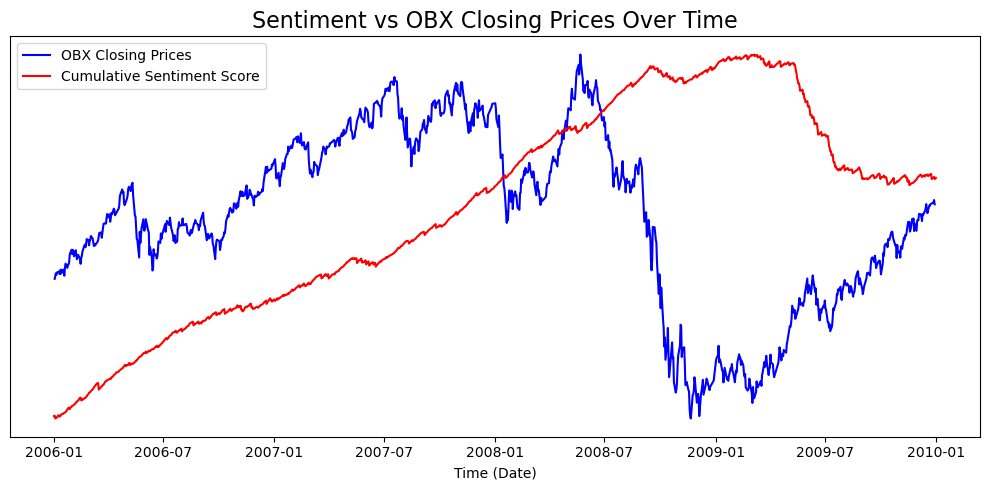

In [504]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

obx_data['normalized_close'] = scaler.fit_transform(obx_data[['Close']])
avg_sentiment['normalized_cumulative'] = scaler.fit_transform(avg_sentiment[['adjusted_cumulative']])

plt.figure(figsize=(10, 5))
plt.plot(obx_data['normalized_close'], label='OBX Closing Prices', color='blue')
plt.plot(avg_sentiment['date'], avg_sentiment['normalized_cumulative'], label='Cumulative Sentiment Score', color='red')

plt.title('Sentiment vs OBX Closing Prices Over Time', fontsize=16)
plt.xlabel('Time (Date)')

plt.yticks([])

plt.legend()
plt.savefig('OBXandSentimentPlot.png')
plt.tight_layout()
plt.show()

In [505]:
# TODO: Find the correlation

Pearsons correlation: -0.355
